In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from laserembeddings import Laser
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
import math
from tqdm import tqdm
import translators as ts
from langdetect import detect
import json
from datetime import datetime, timedelta
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings("ignore")

c:\Users\asus-zen\anaconda3\envs\py31013\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to C:\Users\asus-
[nltk_data]     zen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#To count the number of reactions in the dataframe
def countreactions(df):
    return df['reactions'].apply(lambda x: sum_numbers_in_string(x)).sum()

#To count the number of different conversations in the dataframe
def totconversations(df):
    return df.groupby('conversation_id').count().shape[0]

#To compute the mean length of the conversations in the dataframe
def meanconversationlength(df):
    return df.shape[0] / totconversations(df)

#To count the number of messages per group in the dataframe
def messagespergroup(df):
    return df.groupby('group')['group'].count()

#To count the number of conversations per group in the dataframe
def conversationspergroup(df):
    convpergroup = df.groupby(['group','conversation_id'])['conversation_id'].size()
    return convpergroup.groupby('group').count()

#To compute the mean length of the conversations per group in the dataframe
def lengthofconversationspergroup(df):
    return messagespergroup(df)/conversationspergroup(df)

def printstatistics(predf):
    pd.set_option('display.max_rows', None)
    print("Total Number of Conversations:")
    print(totconversations(predf))
    print("\nTotal Number of Messages:")
    print(predf.shape[0])
    print("\nTotal Number of Reactions:")
    print(countreactions(predf))
    print("\nMessages per Conversation in average:")
    print(meanconversationlength(predf))
    print("\nConversations per group:")
    convpergroup = conversationspergroup(predf)
    print(convpergroup)

    # First plot
    plt.figure()
    colors = plt.cm.viridis(np.linspace(0, 1, len(convpergroup)))
    convpergroup.plot(kind='bar', title='#Conversations per group', color=colors)
    plt.show()  # Display the first plot

    print("Messages per Conversations per Group in Average:")
    locpergroup = lengthofconversationspergroup(predf)
    print(locpergroup)

    plt.figure()
    colors = plt.cm.viridis(np.linspace(0, 1, len(locpergroup)))
    locpergroup.plot(kind='bar', title='#Messages per Conversations per Group in Average', color=colors)
    plt.show()  # Display the first plot

In [5]:
df = pd.read_excel('data_analysis\labeling_data.xlsx')
df = df.set_index('index')
df['date'] = pd.to_datetime(df['date'])
df.drop(columns=['Unnamed: 9'], inplace=True)

In [6]:
df.head()

,id,group,sender,text,reply,date,reactions,topic,keywords
0,19045,https://t.me/joinchat/8Z9Y0f3ymPw3NzNk,553874639,"Hi, I'm still looking for a team to do the RAS...",NaN,2023-10-15 07:46:57+00:00,{},1. Project/assignment/homework,NaN
1,19177,https://t.me/joinchat/8Z9Y0f3ymPw3NzNk,6532068962,Does anyone still have a spot for the requirem...,NaN,2023-10-26 08:16:19+00:00,{},1. Project/assignment/homework,NaN
2,19160,https://t.me/joinchat/8Z9Y0f3ymPw3NzNk,414785325,for all sections?,19159.0,2023-10-23 22:32:09+00:00,{},1. Project/assignment/homework,NaN
3,19004,https://t.me/joinchat/8Z9Y0f3ymPw3NzNk,5452059839,"Hi guys, we are two people looking for a 3rd m...",NaN,2023-10-10 21:05:16+00:00,{},1. Project/assignment/homework,NaN
4,27730,https://t.me/joinchat/QeBrjx97pwI4NDVk,163752298,That of the subsystem with H = 0,NaN,2023-06-22 11:23:20+00:00,{},1. Project/assignment/homework,NaN


In [37]:
def extract_labels_from_labeled_data(pdf, window_size):
    df = pdf.copy()
    df['labels'] = np.nan
    i = 0
    for start_idx in range(len(df) - window_size + 1):
        i = start_idx + window_size
        window = np.arange(start_idx, start_idx + window_size)
        window_df = df.iloc[window]
        lastconversation = window_df.iloc[-1]["conversation_id"]
        df.at[i, 'labels'] = lastconversation in window_df.iloc[:-1]["conversation_id"].values
    return df

In [38]:
#Use 'en' for english and 'it' for italian as la
def embed_messages(messages, language):
    langs = [language for i in range(len(messages))]
    laser = Laser()
    embeddings = laser.embed_sentences(messages, lang=langs)
    return embeddings

In [53]:
def return_languages(p_df):
  laser = Laser()
  df = p_df.copy()
  nones = []
  langs = []
  for index in range(len(df)):  # Loop over actual indices
    text = df.iloc[index]['text']
    try:
      langs.append(detect(text))
    except:
      langs.append('en')

  return langs

In [40]:
langs = return_languages(df)

100%|██████████| 2099/2099 [00:13<00:00, 156.53it/s]


In [41]:
def embed_dataframe(p_df, langs):
    df = p_df.copy() 
    laser = Laser()
    embeddings = laser.embed_sentences(df['text'], lang=langs)
    df['embeddings'] = [vec for vec in embeddings]
    return df

In [42]:
emb_df = embed_dataframe(lb_df, langs)

In [43]:
emb_df.head()

,id,group,sender,text,reply,date,reactions,conversation_id,labels,embeddings
index,,,,,,,,,,
1,21738,https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ,64987268,"guys hello everyone, I don't know if I'm in th...",NaN,2023-11-14 10:14:46+00:00,{},0,NaN,"[0.027935296, 0.0027894361, 0.013751687, 0.021..."
2,21739,https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ,962690321,/search infosec,21738.0,2023-11-14 13:10:56+00:00,{},0,NaN,"[0.004933492, 0.00015138902, 0.0047318344, 0.0..."
3,21743,https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ,64987268,Thank you,NaN,2023-11-14 13:50:36+00:00,{},0,NaN,"[0.0033860358, 0.0022366368, 0.00054005336, 0...."
4,21749,https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ,705891914,For automation how is it?\n#Link,NaN,2023-11-16 10:04:12+00:00,{},1,NaN,"[0.00721515, 0.013493194, 0.00070514565, 0.003..."
5,21750,https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ,705891914,Is there any specification on which I can focu...,NaN,2023-11-16 10:05:11+00:00,{},1,True,"[0.042851254, 0.0017440224, 0.030211458, 0.013..."


In [ ]:
k = 5
lb_df = extract_labels_from_labeled_data(emb_df, 5)

In [14]:
def average_k_cosine_similarity(embeddings, k):
    tmp_similarity = []
    for i in np.arange(k):
        if i != k-1:
            tmp_similarity.append(np.dot(embeddings[k-1], embeddings[i]) / (np.linalg.norm(embeddings[k-1]) * np.linalg.norm(embeddings[i])))
    return np.mean(tmp_similarity)

def cosine_similarities_last_k_sliding_window (p_df, k):
    df = p_df.copy()
    df['similarities'] = np.nan
    j = k
    for i in np.arange(len(df['embeddings'])-k+1):
        window = [emb for emb in df.iloc[i:i+k]['embeddings']]
        df.at[j,'similarities'] = average_k_cosine_similarity(window, k)
        j = j+1
    return df

In [15]:
sim_df = cosine_similarities_last_k_sliding_window(emb_df, k)

In [16]:
sim_df.head()

,id,group,sender,text,reply,date,reactions,conversation_id,labels,embeddings,similarities
index,,,,,,,,,,,
1,21738,https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ,64987268,"guys hello everyone, I don't know if I'm in th...",NaN,2023-11-14 10:14:46+00:00,{},0,NaN,"[0.027935296, 0.0027894361, 0.013751687, 0.021...",NaN
2,21739,https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ,962690321,/search infosec,21738.0,2023-11-14 13:10:56+00:00,{},0,NaN,"[0.004933492, 0.00015138902, 0.0047318344, 0.0...",NaN
3,21743,https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ,64987268,Thank you,NaN,2023-11-14 13:50:36+00:00,{},0,NaN,"[0.0033860358, 0.0022366368, 0.00054005336, 0....",NaN
4,21749,https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ,705891914,For automation how is it?\n#Link,NaN,2023-11-16 10:04:12+00:00,{},1,NaN,"[0.00721515, 0.013493194, 0.00070514565, 0.003...",NaN
5,21750,https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ,705891914,Is there any specification on which I can focu...,NaN,2023-11-16 10:05:11+00:00,{},1,True,"[0.042851254, 0.0017440224, 0.030211458, 0.013...",0.366742


In [17]:
sim_df = sim_df[sim_df['similarities'].notna()]
sim_df.reset_index(drop=True, inplace=True)

In [28]:
sim_df.head()

,id,group,sender,text,reply,date,reactions,conversation_id,labels,embeddings,similarities
0,21750,https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ,705891914,Is there any specification on which I can focu...,NaN,2023-11-16 10:05:11+00:00,{},1,True,"[0.042851254, 0.0017440224, 0.030211458, 0.013...",0.366742
1,21752,https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ,1010012648,"Hi, sorry, I would like to know if these 2 PCs...",NaN,2023-11-16 10:34:11+00:00,{},2,False,"[0.018145915, 0.005266279, -0.0022878223, 0.00...",0.426847
2,21760,https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ,137242583,I would say that you are already at the lower ...,21750.0,2023-11-16 16:25:39+00:00,{},1,True,"[0.002974552, -6.782907e-05, -0.00045646634, 0...",0.434967
3,21761,https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ,137242583,"Yes, they both have excellent characteristics,...",21752.0,2023-11-16 16:27:30+00:00,{'👍': 1},2,True,"[0.030071005, 0.012075688, 0.0075600846, 0.057...",0.564960
4,21762,https://t.me/joinchat/OOC4qk2QS1FM37aETHuzWQ,705891914,Well it seems good to me good except the medio...,21760.0,2023-11-16 16:58:04+00:00,{},1,True,"[0.027277451, 0.018283889, -0.002495405, 0.043...",0.554355


In [22]:
#To find a suitable treshold for the cosine similarity method
def find_suitable_treshold(df):
    treshold = 0
    numofindices = 0
    totconv = totconversations(df)
    while(numofindices < totconv):
        indices = [i for i, num in enumerate(df['similarities']) if num < treshold]
        numofindices = len(indices)
        treshold = treshold + 0.001
    return treshold

In [ ]:
sim

In [29]:
labels = [lb for lb in sim_df['labels']]

treshold = find_suitable_treshold(sim_df)
predictions = []
for sim in sim_df['similarities']:
    
    if sim < treshold:
        predictions.append(False)
    else:
        predictions.append(True)

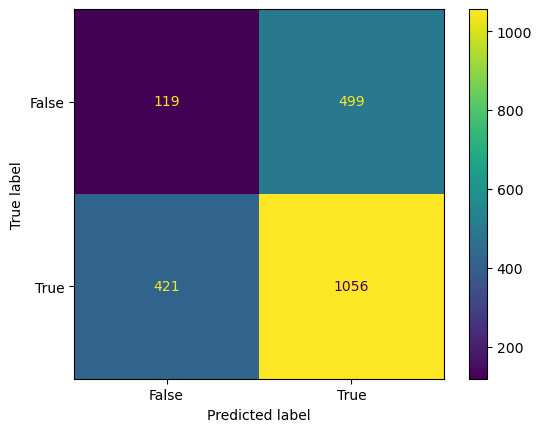

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(labels, predictions)

plt.show()

In [54]:
def test_cosine_similarity_method(df, k):

    #labeling data
    df = extract_labels_from_labeled_data(df, k)

    #Cosine similarities
    df = cosine_similarities_last_k_sliding_window(df, k)

    #Removing NaNs
    df = df[df['similarities'].notna()]
    df.reset_index(drop=True, inplace=True)

    labels = [lb for lb in df['labels']]

    treshold = find_suitable_treshold(df)

    predictions = []
    for sim in df['similarities']:
        
        if sim < treshold:
            predictions.append(False)
        else:
            predictions.append(True)

    return labels, predictions

In [59]:
def test_cosine_similarity_method(df, k, t):

    #labeling data
    df = extract_labels_from_labeled_data(df, k)

    #Cosine similarities
    df = cosine_similarities_last_k_sliding_window(df, k)

    #Removing NaNs
    df = df[df['similarities'].notna()]
    df.reset_index(drop=True, inplace=True)

    labels = [lb for lb in df['labels']]

    predictions = []
    for sim in df['similarities']:
        
        if sim < t:
            predictions.append(False)
        else:
            predictions.append(True)

    return labels, predictions

In [50]:
def return_metrics(labels, predictions):
    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    precision = tp/(tp+fp)
    return accuracy, sensitivity, specificity, precision

In [60]:
def print_results_table(df, ki, ke):
    headers = ["Window Size"]
    range = np.arange(-0.1, 0.12, 0.02)
    range = range.tolist()
    np.set_printoptions(formatter={'float':"{0:0.2f}".format})
    for h in range:
        if h < 0.01 and h > -0.01:
            value = "T"
        elif h > 0:
            value = "T+"+str(np.around(h,2))
        elif h < 0:
            value = "T" + str(np.around(h,2))

        headers.append(value)

    myTable = []
    range = np.arange(ki, ke+1)
    range = range.tolist()
    for k in range:
        row = [k]
        simdf = cosine_similarities_last_k_sliding_window(df, k)
        treshold = find_suitable_treshold(simdf)
        strings = []
        for t in tqdm(np.arange(treshold-0.1, treshold+0.13, 0.02)):
            labels, predictions = test_cosine_similarity_method(df, k, t)
            accuracy, sensitivity, specificity, precision = return_metrics(labels, predictions)
            np.set_printoptions(formatter={'float':"{0:0.2f}".format})
            string = "treshold = "+ str(np.around(t,2)) + "\naccuracy = " + str(np.around(accuracy,2)) + "\nsensitivity = " + str(np.around(sensitivity,2)) + "\nspecificity = " + str(np.around(specificity,2)) + "\nprecision = " + str(np.around(precision,2))
            strings.append(string)
            
        range1 = np.arange(len(strings)-1)
        range1.tolist()
        for i in range1:
            row.append(strings[i])
        
        myTable.append(row)
        

    return myTable, headers

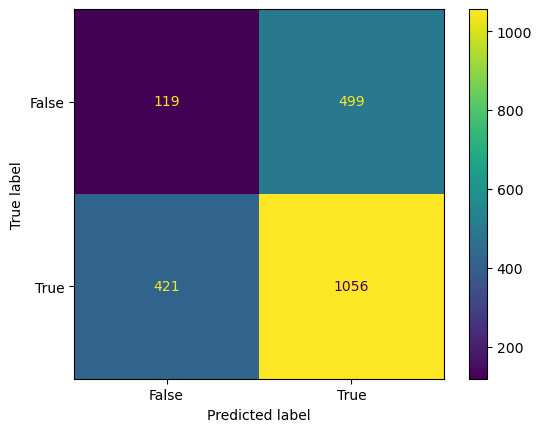

In [47]:
ConfusionMatrixDisplay.from_predictions(labels, predictions)

plt.show()

In [32]:
def return_metrics(labels, predictions):
    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    precision = tp/(tp+fp)
    return accuracy, sensitivity, specificity, precision

In [65]:
import openpyxl
from openpyxl.utils.dataframe import dataframe_to_rows

def save_results(table, headers, name):

    results_df = pd.DataFrame(table, columns=headers)
    # Creare un nuovo file Excel
    workbook = openpyxl.Workbook()

    # Selezionare il foglio di lavoro attivo (il primo foglio di lavoro di default)
    sheet = workbook.active

    # Scrivere i dati del DataFrame nel foglio di lavoro
    for r_idx, row in enumerate(dataframe_to_rows(results_df, index=False), 1):
        for c_idx, value in enumerate(row, 1):
            sheet.cell(row=r_idx, column=c_idx, value=value)

    # Salvare il file Excel
    workbook.save(filename=name)

In [63]:
table, headers = print_results_table(emb_df, 2, 10)

100%|██████████| 12/12 [00:23<00:00,  1.93s/it]


In [66]:
#save_results(table, headers, "cos_sim_results.xlsx")

In [ ]:
def translate_messages(df_original):
    import translators as ts
    translation_text_google = []
    df_translated = df_original.copy()
    for i in tqdm(range(len(df_translated))):
        try:
            original_text = df_translated['text'].iloc[i]
            detected_language = detect(original_text)
            if detected_language != 'en':
                message_google = ts.translate_text(query_text=original_text, translator='google', from_language='auto', to_language='en')
                translation_text_google.append(message_google)
            else:
                translation_text_google.append(original_text)
        except:
            translation_text_google.append(original_text)

    df_translated['text'] = translation_text_google
    return df_translated